Magroove Data Science Test
=======================

### Intro
The goal of this test is to access your ability to use data science to tackle a real life issue. Because the nature of the issue is just so complex, we do not expect your solution to be definitive or highly performant - we actually don’t really care about the accuracy of your results at all. What we really care about is your thought process or the way you take an issue, distill it into something solvable by a machine and turn all that into code. As you may imagine at this point, this test will revolve around a machine learning problem - a classification one to be more specific, so let’s get to it.

### The Problem
When uploading an album to digital streaming platforms (DPSs) like Spotify, Apple or so on, it is important that all the metadata that goes with that album to be accurate. Metadata includes basic information like the album name, the year when it was recorded, the artists involved in the tracks and much more. In this exercise we are particularly interested in a specific element of the metadata - language.

Language is an important piece of metadata as it helps the DPSs recommend a given album to listeners that understand that language and will most likely appreciate it. Because of that, DSPs are quite strict with the correct language being assigned when receiving an album.

However, it does occur quite frequently for our users to incorrectly fill the language field in our form when submitting an album, which later leads to conflicts between the given user, our company and the DSPs. The goal of this test then is to work on a solution for a simplified version of such problem.

Together with this description you will find two files - dataset-hindi.csv and dataset-spanish.csv. The names are quite intuitive, each contains metadata from albums we already distribute and that we know their metadata are either written in Spanish or Hindi. Each CSV contains three columns - artist_name, release_name and song_name. Even though the names are rather intuitive, you should pay attention to the fact that the columns artist_name and release_name tend to have repeated entries as the same artist can have several albums and an album can have several songs.

**Your goal then is to create a model to classify future metadata as either written in Spanish or Hindi.**

### The deliverables
We expect to receive from you a single python script (run.py) and a requirements (requirements.txt) file listing all the dependencies to run it. Your script should be written using Python 3.x and it should output a model we could later use for inference in a production-like environment. You can use any packages or libraries you want as long as you don’t use any pre-trained model. You are also forbidden to use third party APIs or services for language inference like AWS Comprehend or GCP Translation. Your single script should contain everything from data cleaning and preprocessing all the way to model training and inference.

### Evaluation and final thoughts

Again, even though accuracy is always a good metric, our primary focus will definitely not be performance (we would be running a Kaggle competition if it was =) ). Our attention will be on the logic you used to try and solve the issue and how it translated into code. So don’t worry if your model performs poorly at the end - we would choose nine out of ten times a poor model performance with a smart approach and attempt to solve the problem in question.

And finally, don’t hesitate to get in touch if you have any questions, doubts or simply need a kick start. Here at Magroove we have a strong culture of helping each other out - so you can definitely count on us - and we promise that any calls for help will not affect your evaluation at all. In the end solving challenging problems is mostly about asking the right questions, so well thought questions are more than welcome. So good luck with your test and keep us in the loop!


##  Visualização dos Dados

In [1]:
import pandas as pd
import numpy as np
import unidecode
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.compose import make_column_transformer
from sklearn.feature_extraction.text import CountVectorizer # (converter as colunas em um array)
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# Function to Reduce repeated characters and punctuations
def reducing_incorrect_character_repeatation(text):
    """
    This Function will reduce repeatition to two characters 
    for alphabets and to one character for punctuations.
    
    arguments:
         input_text: "text" of type "String".
         
    return:
        value: Finally formatted text with alphabets repeating to 
        two characters & punctuations limited to one repeatition 
        
    Example:
    Input : Realllllllllyyyyy,        Greeeeaaaatttt   !!!!?....;;;;:)
    Output : Reallyy, Greeaatt !?.;:)
    
    """
    # Pattern matching for all case alphabets
    Pattern_alpha = re.compile(r"([A-Za-z])\1{1,}", re.DOTALL)
    
    # Limiting all the  repeatation to two characters.
    Formatted_text = Pattern_alpha.sub(r"\1\1", text) 
    
    # Pattern matching for all the punctuations that can occur
    Pattern_Punct = re.compile(r'([.,/#!$%^&*?;:{}=_`~()+-])\1{1,}')
    
    # Limiting punctuations in previously formatted string to only one.
    Combined_Formatted = Pattern_Punct.sub(r'\1', Formatted_text)
    
    # The below statement is replacing repeatation of spaces that occur more than two times with that of one occurrence.
    Final_Formatted = re.sub(' {2,}',' ', Combined_Formatted)
    return Final_Formatted

## Análise Exploratória

In [3]:
# Importando os dados
df_sp = pd.read_csv('dataset-spanish.csv', header = 0)
df_hi = pd.read_csv('dataset-hindi.csv', header = 0)

In [4]:
# Visualização dos dados
df_sp.sample(5)

,artist_name,release_name,song_name
3943,Manorth,Descomposición\n,Summer
4559,Los Jr,El Larios,El Larios
1100,Myriam Hernandez,Myriam Hernández,Quiero Cantarle Al Amor
1900,B4st4rdo,Volacuatica6969,Homenajepro
3858,Su Majestad La Brissa,40º Aniversario: Se Va Muriendo Mi Alma,Vas a Pagar


In [5]:
# Visualização dos dados
df_hi.sample(5)

,artist_name,release_name,song_name
304,Diksha Chaubey,Walking Home,Older
1806,Rrabi Bir,Mere Shambhu,Mere Shambhu Rrabi Bir
3759,Om Sompura,Alag Asmaan,Alag Asmaan
2336,Ganesh Kumar Hempur,Suno Na Nagpuri,Suno Na Nagpuri
1080,Mukesh Karma,Mera Hota,Mera Hota


In [6]:
# Checking the dataset lenght
print(f'Spanish dataset length: {len(df_sp)} \nHindi dataset lenght: {len(df_hi)}')

Spanish dataset length: 5000 
Hindi dataset lenght: 5000


In [7]:
# Describe dos dados
df_sp.describe()


,artist_name,release_name,song_name
count,5000,4999,4999
unique,1415,1870,4702
top,Various,Cumbias Sonideras,Title Error
freq,134,134,24


In [8]:
df_hi.describe()

,artist_name,release_name,song_name
count,5000,5000,4997
unique,2436,4034,4616
top,Visual Chinmay,Vibeee:),Title Error
freq,134,59,33


## Data Cleaning

> Before starting the data cleaning process, I'll add the column 'Idiom' in the datasets so I can already concatenate them to make the cleaning for the whole dataset

In [9]:
# Adding a 'Idiom' column
df_sp['Idiom'] = 'Spanish'
df_hi['Idiom'] = 'Hindi'

In [10]:
# Concatenating the datasets
df = pd.concat([df_sp, df_hi])
len(df)

10000

In [11]:
print(df.duplicated().sum())

154


In [12]:
# Dropping duplicated rows
df.drop_duplicates(inplace= True)

In [13]:
# Checkin missing values
df.isna().sum()

artist_name     0
release_name    1
song_name       4
Idiom           0
dtype: int64

In [14]:
# Dropping the rows with missing values
df.dropna(inplace=True)

In [15]:
# Checking dataset lenght after dropping the duplications for the spanish and the hindi (so we can see if it's still balanced)
print(f"Spanish dataset length: {len(df[(df.Idiom == 'Spanish')])} \nHindi dataset lenght: {len(df[(df.Idiom == 'Hindi')])}")

Spanish dataset length: 4935 
Hindi dataset lenght: 4906


In [16]:
df.describe()

,artist_name,release_name,song_name,Idiom
count,9841,9841,9841,9841
unique,3843,5891,9299,2
top,Various,Cumbias Sonideras,Title Error,Spanish
freq,134,134,31,4935


In [17]:
# Taking a deep look into the variables to clean it properly
df['song_name'].value_counts()

Title Error              31
Intro                     9
TITLE_ERROR               7
Contigo                   6
Ranjha                    5
                         ..
Me Llevo a Las Gyales     1
Yuca                      1
Cash Out                  1
Lunes Rahib               1
The Devue                 1
Name: song_name, Length: 9299, dtype: int64

In [18]:
# I'll remove the rows with Title Error (and TITLE_ERROR) and also the Intro songs, since it doesn't mean much about the idiom of the song (which is what we are looking for in this project)
df = df[(df.song_name != 'Title Error') & (df.song_name != 'TITLE_ERROR') & (df.song_name.str.startswith('Intro') == False)]

In [19]:
df.describe()

,artist_name,release_name,song_name,Idiom
count,9781,9781,9781,9781
unique,3822,5864,9283,2
top,Various,Cumbias Sonideras,Contigo,Spanish
freq,134,134,6,4903


In [20]:
# Removing possible double whitespace in the text
for i in range(0,len(df.columns)):
    for j in range(0, len(df)):
        df[(df.columns.values[i])].values[j] = re.sub(r'\s+', ' ', df[(df.columns.values[i])].values[j])

In [21]:
df.sample(5)

,artist_name,release_name,song_name,Idiom
2865,Rorong Apum,Lodi Pe Mitinam No,Lodi Pe Mitinam No,Hindi
3083,Jaikant Bhardwaj,Kabhi Kabhi Mere Dil Main (recreated),677537529901879 7409671830843308655 N (1),Hindi
2975,Shivamm Shivone,Mai Hosh Me Hu,Mai Hosh Me Hu,Hindi
3676,Bhupesh Khurana,Jazbaat,Jazbaat - Bhupesh Khurana Rap Song 2021 (Offic...,Hindi
3555,Cyphrix,Revelation,Revelation,Spanish


## Pre-Processing

### Removing accented characters

In [22]:
# Removing accented characters
for i in range(0,len(df.columns)):
    for j in range(0, len(df)):
        df[(df.columns.values[i])].values[j] = unidecode.unidecode(df[(df.columns.values[i])].values[j])

In [23]:
df.sample(5)

,artist_name,release_name,song_name,Idiom
1021,Jorel,Amor Artificial,Amor Artificial,Spanish
4592,Surjan Pachwara,koii koii yaad puraanii,koii koii yaad praannii hai,Hindi
214,Aditi Iyangar,One Night,One Night,Hindi
2027,Hostil MC..,Inmunizacion...,Hostil Mc X Joe Phantom .....Error..(ceda muse...,Spanish
2581,Jainesh V,Hua Hai Aaj Pehli Baar,Hua Hai Aaj Pehli Baar (Slowed and Reverb),Hindi


### Converting the dataset to lowercase

In [24]:
# Converting the dataset to lowercase
for i in range(0,len(df.columns)):
    for j in range(0, len(df)):
        df[(df.columns.values[i])].values[j] = (df[(df.columns.values[i])].values[j]).lower()

In [25]:
df.sample(5)

,artist_name,release_name,song_name,Idiom
255,baby brazy,no hay tiempo,no hay tiempo,spanish
3030,q kya,hum kya jane,ek ladki ko dekha toh aisa laga,hindi
1124,a.r. rehman,maa tuje salam remix,2-maa tuje salam,hindi
3334,rachi la para,chapa par tras,chapa pa tras,spanish
620,boleros...en la noche,lost & found latin music tapes vol. vii,no niegues que me quisiste-alfredo sadel,spanish


### Reducing repeated characters and punctuations

In [26]:
# Reducing repeated characters and punctuations
for i in range(0,len(df.columns)):
    for j in range(0, len(df)):
        df[(df.columns.values[i])].values[j] = reducing_incorrect_character_repeatation(df[(df.columns.values[i])].values[j])

In [27]:
df.sample(5)

,artist_name,release_name,song_name,Idiom
1361,sjm dj remix collection,dialogue,dialogue,hindi
3551,rishabh,thodi jagha,master (83),hindi
1238,janet lago,"janet, mis canciones my songs, at piano style",the city of the sun,spanish
2892,surade,surili akhiyon but lofi,surili akhiyon wale lofi flip cover rahat fate...,hindi
4291,matias oficial,dame fuerza,dame fuerza,spanish


### Removing Special Characters

In [28]:
# Removing Special Characters and also numbers(since the numbers doesn't give any hint regarding idiom)
for i in range(0,len(df.columns)):
    for j in range(0, len(df)):
        df[(df.columns.values[i])].values[j] = re.sub("[.,;/0-9!?¿%@|~'#+:()-]", '', df[(df.columns.values[i])].values[j])

In [29]:
df.sample(5)

,artist_name,release_name,song_name,Idiom
3985,raul alberto cordoba,insomnio pr,paz interior,spanish
2489,maruf sakirin,bol na halke halke,bol na halke halke,hindi
2379,cyphero kzie on the beat,sannata,santa,hindi
4229,zohn tandon bey,bong oi mirlori,bong oi mirlori,hindi
2689,esteban estevez,salgan a bailar,esta noche quiero brandy,spanish


In [30]:
# Visualizing data 
df.sort_values('song_name')

,artist_name,release_name,song_name,Idiom
3205,walther pro,resonancia,,spanish
1316,cxcile,,,spanish
671,zevna javi cheuke,jardin botanico,,spanish
4036,zanmala,,,spanish
1908,tchad,ivory waali irony,,hindi
...,...,...,...,...
1792,d i c,zona sur rkt,zona sur rkt,spanish
585,soledad bravo live dec,lost and found latin music tapes,zorongo,spanish
2510,zeta,zta music sessions vol,zta music sessions vol,spanish
1791,bsk brothers,absolute desi vol,zul zul vahe,hindi


In [31]:
# Remove the rows where we got empty values after the pre-processing and couldn't be removed by .dropna()
df[(df.song_name == '')]

,artist_name,release_name,song_name,Idiom
671,zevna javi cheuke,jardin botanico,,spanish
1316,cxcile,,,spanish
1998,oniricboii,,,spanish
2348,seven,,,spanish
2903,j boi,,,spanish
2921,jadix,tena,,spanish
3205,walther pro,resonancia,,spanish
4028,ruido julio,,,spanish
4036,zanmala,,,spanish
1908,tchad,ivory waali irony,,hindi


In [32]:
df = df[(df.song_name != '') & (df.release_name != '') & (df.artist_name != '')]

In [33]:
df.sample(5)

,artist_name,release_name,song_name,Idiom
3552,pr,pedro,eyes,spanish
3754,khushi,shikhandi a rap on transgenders,shikhandi a rap on transgenders,hindi
2087,subhranil neogi,choo lo remix subhranil,choo lo the local train,hindi
2415,old vs new,raj burban & deepshikha,gujarati love audio wing project,hindi
1716,apni nagpuri adda,ho o dear darling tore naam,ho o dear darling tore naam,hindi


> We could see that some albuns had the 'vol' in its end (indicating which volum it is). Since it's a generic word, it won't help to keep them in our dataset. Let's remove the word then.
 Now that we took the numbers out, lets see how many we have left

In [34]:
print(df['release_name'].str.endswith('vol ').sum())
print(df['release_name'].str.endswith('vol').sum())

49
49


In [35]:
# Removing 'vol' and 'vol ' in the end of the albuns
for i in range(0, len(df)):
    if df.release_name.str.endswith('vol ').values[i]:
        df.release_name.values[i] = df.release_name.values[i].replace('vol ', '')
    elif df.release_name.str.endswith('vol').values[i]:
        df.release_name.values[i] = df.release_name.values[i].replace('vol', '')

In [36]:
# Checking if they were fully removed.
print(df['release_name'].str.endswith('vol ').sum())
print(df['release_name'].str.endswith('vol').sum())

0
0


In [37]:
df.sample(5)

,artist_name,release_name,song_name,Idiom
529,billos caracas boys & sonora matancera,lost and found latin music tapes vol ii,sin corazon en el pecho,spanish
1487,davis gm,perfecta ilusion,perfecta ilusion,spanish
920,gryd,godzilla,godzilla,spanish
504,billos caracas boys & sonora matancera radio b...,lost and found latin music tapes vol ii,valencia senorial,spanish
4471,anurag dogra,aukaat,aukaat,hindi


In [38]:
# Transforming the target variable ('Idiom') in 0 and 1 ("0" -> 'hindi ; "1" -> spanish)
df['Idiom'] = np.where((df['Idiom']) == 'spanish', 1,0)

In [39]:
df['Idiom'].value_counts()

0    4875
1    4873
Name: Idiom, dtype: int64

In [40]:
df.sample(5)

,artist_name,release_name,song_name,Idiom
4252,titanexx,extension excesiva,sin adaptacion no hay victoria,1
4883,vivan studio paparda,chand sitara su top,chand sitara su top,0
354,zi,marwei,marwei,0
2394,ag sandino,me canse,me canse,1
3162,dj selvin,en la disco freestyle,en la disco freestyle,1


## Model Training

### Train and Test Dataset

Firstly, I'll use all the 3 variables as target. Later I'll try using only the song_name (since the we have repeated values in the album name and artist, and also artist name do not neceesary mean anything about the idiom)


In [41]:
x = (df.drop(['Idiom'], axis = 1)) # predictors
y = (df['Idiom']) # target

In [42]:
type(x)

pandas.core.frame.DataFrame

In [43]:
# Transforming the variables to use in our algorith
cv = CountVectorizer()
ct = make_column_transformer((cv,'artist_name'),(cv,'song_name'),(cv,'release_name'))
X = ct.fit_transform(x)

In [44]:
# Separating them into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 19)

c:\Users\rafajovelho\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


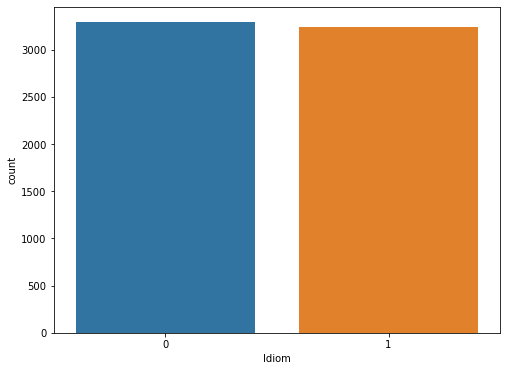

In [45]:
# Verifying if the variable is balanced
plt.figure(figsize = (8,6))

ax = sns.countplot(y_train)

In [46]:
model = MultinomialNB()
model.fit(X_train, y_train)

MultinomialNB()

## Score

In [47]:
score = model.score(X_test, y_test)
print(f' We got {round(score*100,2)}% of accuraccy')

 We got 95.74% of accuraccy


In [48]:
# Confusion Matrix
predictions = model.predict(X_test)
print(metrics.confusion_matrix(y_test, predictions))

[[1500   84]
 [  53 1580]]


In [49]:
# Precision
print(metrics.classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      1584
           1       0.95      0.97      0.96      1633

    accuracy                           0.96      3217
   macro avg       0.96      0.96      0.96      3217
weighted avg       0.96      0.96      0.96      3217



I'll be testing the same model, but now using only the "song_name" as predictor variable. This one might be a more generic model.

### Train and Test Dataset

In [50]:
x = np.array((df['song_name'])) # predictors
y = np.array((df['Idiom'])) # target

In [51]:
cv = CountVectorizer()
X = cv.fit_transform(x)

In [52]:
# Separating them into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state= 19)

c:\Users\rafajovelho\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


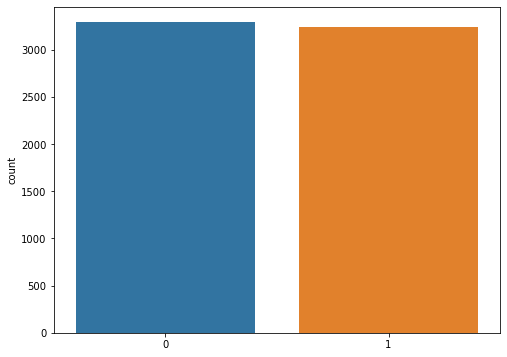

In [53]:
# Verifying if the variable is balanced
plt.figure(figsize = (8,6))

ax = sns.countplot(y_train)

In [54]:
model1 = MultinomialNB()
model1.fit(X_train, y_train)

MultinomialNB()

### Score

In [55]:
score = model1.score(X_test, y_test)
print(f' We got {round(score*100,2)}% of accuraccy')

 We got 87.41% of accuraccy


In [56]:
predictions = model1.predict(X_test)
print(metrics.confusion_matrix(y_test, predictions))
print(metrics.classification_report(y_test, predictions))

[[1289  295]
 [ 110 1523]]
              precision    recall  f1-score   support

           0       0.92      0.81      0.86      1584
           1       0.84      0.93      0.88      1633

    accuracy                           0.87      3217
   macro avg       0.88      0.87      0.87      3217
weighted avg       0.88      0.87      0.87      3217



We got a worse result using only the 'song_name' variable. But it actually might be better for futures datasets, since for this one we have a lot of repeated values for albuns and artists name.

### KNN

In [57]:
x = (df.drop(['Idiom'], axis = 1)) # predictors
y = (df['Idiom']) # target

In [58]:
cv = CountVectorizer()
ct = make_column_transformer((cv,'artist_name'),(cv,'song_name'),(cv,'release_name'))
X = ct.fit_transform(x)

In [59]:
# Separating them into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)

In [60]:
model2 = KNeighborsClassifier()
model2.fit(X_train, y_train)

KNeighborsClassifier()

In [61]:
score = model2.score(X_test, y_test)
print(f' We got {round(score*100,2)}% of accuraccy')

 We got 80.11% of accuraccy


In [62]:
predictions = model2.predict(X_test)
print(metrics.confusion_matrix(y_test, predictions))
print(metrics.classification_report(y_test, predictions))

[[1042  604]
 [  36 1535]]
              precision    recall  f1-score   support

           0       0.97      0.63      0.77      1646
           1       0.72      0.98      0.83      1571

    accuracy                           0.80      3217
   macro avg       0.84      0.81      0.80      3217
weighted avg       0.85      0.80      0.80      3217



Now using only song_name as predictor

In [63]:
x = np.array((df['song_name'])) # predictors
y = np.array((df['Idiom'])) # target

In [64]:
cv = CountVectorizer()
X = cv.fit_transform(x)

In [65]:
# Separating them into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33)

In [66]:
# Trainning model
model3 = KNeighborsClassifier()
model3.fit(X_train, y_train)

KNeighborsClassifier()

In [67]:
# Score
score = model3.score(X_test, y_test)
print(f' We got {round(score*100,2)}% of accuraccy')

 We got 74.32% of accuraccy


In [68]:
predictions = model3.predict(X_test)
print(metrics.confusion_matrix(y_test, predictions))
print(metrics.classification_report(y_test, predictions))

[[1573   90]
 [ 736  818]]
              precision    recall  f1-score   support

           0       0.68      0.95      0.79      1663
           1       0.90      0.53      0.66      1554

    accuracy                           0.74      3217
   macro avg       0.79      0.74      0.73      3217
weighted avg       0.79      0.74      0.73      3217



## Conclusion

> We end up having a very good accuracy with the models. Altough the Naive Bayes model had a better perfomance than the KNN one. Also the result was higher when all the variables were used.  

> Even though there were some repeated values for 'artist_name' and 'release_name' , I don't think it'll affect negatively our result, since the name is usually writen with the language the song is.